<a href="https://colab.research.google.com/github/andreysnigirev/Data_Analysis/blob/main/hw04_knn_linreg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Интеллектуальный анализ данных – весна 2025
## Домашнее задание 4: kNN. Линейные модели. Работа с признаками

Правила:

* Домашнее задание оценивается в 10 баллов.

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.  

* Если в задании есть вопрос на рассуждение, то за отсутствие ответа на него балл за задание будет снижен вполовину.

### Задание 1:  Визуализация решающих поверхностей в kNN.

В этом задании мы изобразим решающую поверхность для классификатора kNN, чтобы наглядно увидеть, как классификатор принимает решения для новых объектов. Для простоты будем работать с усеченным датасетом `Palmer Penguins`, содержащим информацию о характеристиках трех видов пингвинов: `Adelie`, `Chinstrap` и `Gentoo`:



*   Species — вид пингвина (целевая переменная).
*   Island — остров, на котором была сделана запись.
*   Clutch Completion — завершенность кладки яиц.
*   Date Egg — закодированная дата откладки яиц (число дней от самой ранней даты в данных).
*   Culmen Length (mm) — длина клюва.
*   Culmen Depth (mm) — глубина клюва.
*   Flipper Length (mm) — длина ласт.
*   Body Mass (g) — масса тела в граммах.
*   Sex — пол особи.
*   Delta 15 N (o/oo) и Delta 13 C (o/oo) — изотопные значения, характеризующие пищевые предпочтения.

Описание полного набора данных и дополнительную информацию о проекте можно найти [здесь](https://allisonhorst.github.io/palmerpenguins/index.html) и [здесь](https://www.kaggle.com/datasets/parulpandey/palmer-archipelago-antarctica-penguin-data?resource=download).

![Palmer Penguins](https://allisonhorst.github.io/palmerpenguins/reference/figures/lter_penguins.png)



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('penguins_data.csv')
data.head(5)

,Species,Island,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
0,Chinstrap,Dream,Yes,382,50.9,19.1,196.0,3550.0,MALE,10.02372,-24.86594
1,Chinstrap,Dream,Yes,741,45.2,17.8,198.0,3950.0,FEMALE,8.88942,-24.49433
2,Gentoo,Biscoe,Yes,744,46.5,13.5,210.0,4550.0,FEMALE,7.99530,-25.32829
3,Chinstrap,Dream,Yes,10,45.2,16.6,191.0,3250.0,FEMALE,9.62357,-24.78984
4,Gentoo,Biscoe,Yes,13,48.4,14.4,203.0,4625.0,FEMALE,8.16582,-26.13971
...,...,...,...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,Yes,382,47.6,18.3,195.0,3850.0,FEMALE,8.83502,-24.65859
340,Adelie,Torgersen,Yes,382,39.7,18.4,190.0,3900.0,MALE,9.29808,-25.23453
341,Adelie,Biscoe,Yes,16,38.6,17.2,199.0,3750.0,FEMALE,8.77322,-26.48973
342,Gentoo,Biscoe,Yes,392,46.6,14.2,210.0,4850.0,FEMALE,8.38289,-26.86352


**Задача 1.1 (0.5 балла)** Есть ли в наборе данных пропущенные значения? Если да, то удалите их. Есть ли в наборе данных категориальные признаки? Если да, то закодируйте их самым оптимальным способом. Аргументируйте свой выбор.

In [ ]:
data.isna().sum()
#видим, что в наборе данных в некоторых столбцах присутствую пропущенные значения

,0
Species,0
Island,0
Clutch Completion,0
Date Egg,0
Culmen Length (mm),2
Culmen Depth (mm),2
Flipper Length (mm),2
Body Mass (g),2
Sex,10
Delta 15 N (o/oo),14


In [ ]:
data = data.dropna() #удалили строки с пропущенными значениями
#также заметим, что есть строки у которых в поле Sex стоит '.' удалим их тоже
data = data.loc[data['Sex'] != "."]

In [ ]:
#в наборе данных есть категориальный признак Island, принимающий несколько значений
#а также категориальные признаки Clutch Completion и Sex, каждый из которых может принимать по 2 значения
#применим к столбцам Clutch Completion и Sex приведение к бинарному типу данных (чтобы были только 0 или 1),
#а к остальным категориальным признакам применим метод one-hot encoding при помощи функции pd.get_dummies()
data['Sex'] = data['Sex'].replace({'MALE': 1, 'FEMALE' : 0})
data['Clutch Completion'] = data['Clutch Completion'].replace({'Yes' : 1, "No" : 0})
data = pd.get_dummies(data, columns= ['Island'], dtype= 'int')
data
#применение one hot encoding выгодно применить в данном случае, ведь таким образом мы можем работать с категориальным признаком
#при этом каждое значение нашего категориального признака будет иметь равный вес при обучении нашей модели

<ipython-input-151-db338ae277d1>:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Sex'] = data['Sex'].replace({'MALE': 1, 'FEMALE' : 0})
<ipython-input-151-db338ae277d1>:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Clutch Completion'] = data['Clutch Completion'].replace({'Yes' : 1, "No" : 0})


,Species,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Island_Biscoe,Island_Dream,Island_Torgersen
0,Chinstrap,1,382,50.9,19.1,196.0,3550.0,1,10.02372,-24.86594,0,1,0
1,Chinstrap,1,741,45.2,17.8,198.0,3950.0,0,8.88942,-24.49433,0,1,0
2,Gentoo,1,744,46.5,13.5,210.0,4550.0,0,7.99530,-25.32829,1,0,0
3,Chinstrap,1,10,45.2,16.6,191.0,3250.0,0,9.62357,-24.78984,0,1,0
4,Gentoo,1,13,48.4,14.4,203.0,4625.0,0,8.16582,-26.13971,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,Chinstrap,1,382,47.6,18.3,195.0,3850.0,0,8.83502,-24.65859,0,1,0
340,Adelie,1,382,39.7,18.4,190.0,3900.0,1,9.29808,-25.23453,0,0,1
341,Adelie,1,16,38.6,17.2,199.0,3750.0,0,8.77322,-26.48973,1,0,0
342,Gentoo,1,392,46.6,14.2,210.0,4850.0,0,8.38289,-26.86352,1,0,0


Целевую категориальную переменную закодируйте в ординальном порядке: Chinstrap = 0, Gentoo = 1, Adelie = 2. Можно воспользоваться [OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html).

Теперь сохраним информацию о признаках в переменную
`X`, а о целевой переменной – в переменную `y`.

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder(categories = [['Chinstrap', 'Gentoo', 'Adelie']])
data['Species'] = enc.fit_transform(data[['Species']])
#при помощи OrdinalEncoder зададим порядковое значение категориальному признаку Species

In [ ]:
#сохраним признаки и целевую переменную в разные датафреймы
y = data['Species']
x = data.iloc[:, 1:]

**Задача 1.2 (0.5 балла)** Используя функцию `train_test_split()`, разделите выборку на тренировочную и тестовую, и долю тестовой выборки задайте равной 0.3. Так как разбиение осуществляется случайным образом, не забудьте зафиксировать `np.random.seed()` для воспроизводимости результатов.

Используйте аргумент `stratify` при разбиении. Почему это важно?

In [ ]:
from sklearn.model_selection import train_test_split
#зададим random.seed для воспроизведения результатов
#разделим выборку на тестовую и тренировочную
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, stratify = y, random_state=42)
#важно использовать аргумент stratify, так как в данных присутствуют категориальные переменные,
#а stratify будет гарантировать то, что в обучающей и тестовой выборках сохранятся пропорции классов
#и выборка будет репрезентативной

**Задача 1.3 (1 балл)** На тренировочной выборке обучите шесть классификаторов kNN, отличающихся только числом соседей. Для первого классификатора число соседей поставьте равным 1, для второго - 3, для третьего – 5, для четвертого – 10, для пятого – 15 и для шестого – 25 (обратите внимание на параметр `n_neighbours` класса `KNeighborsClassifier`). Для обучения используйте только два признака:  `Flipper Length (mm)` и `Body Mass (g)`  – и евклидово расстояние. Не забудьте масштабировать признаки, например, при помощи модуля `StandardScaler`.

Выведите долю правильных ответов на тренировочной и тестовой выборках для каждого классификатора.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

#отнормируем данные, используя StandartScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train[['Flipper Length (mm)', 'Body Mass (g)']])
x_test = scaler.fit_transform(x_test[['Flipper Length (mm)', 'Body Mass (g)']])
clf1 = KNeighborsClassifier(n_neighbors=1, p = 2, n_jobs = -1)
clf1.fit(x_train, y_train)
print("NN  train   test")
print(f'1   {np.round(accuracy_score(y_train, clf1.predict(x_train)), 3)}     {np.round(accuracy_score(y_test, clf1.predict(x_test)), 3)}')
clf2 = KNeighborsClassifier(n_neighbors=3, p = 2, n_jobs = -1)
clf2.fit(x_train, y_train)
print(f'3   {np.round(accuracy_score(y_train, clf2.predict(x_train)), 3)}   {np.round(accuracy_score(y_test, clf2.predict(x_test)), 3)}')
clf3 = KNeighborsClassifier(n_neighbors=5, p = 2, n_jobs = -1)
clf3.fit(x_train, y_train)
print(f'5   {np.round(accuracy_score(y_train, clf3.predict(x_train)), 3)}   {np.round(accuracy_score(y_test, clf3.predict(x_test)), 3)}')
clf4 = KNeighborsClassifier(n_neighbors=10, p = 2, n_jobs = -1)
clf4.fit(x_train, y_train)
print(f'10  {np.round(accuracy_score(y_train, clf4.predict(x_train)), 3)}   {np.round(accuracy_score(y_test, clf4.predict(x_test)), 3)}')
clf5 = KNeighborsClassifier(n_neighbors=15, p = 2, n_jobs = -1)
clf5.fit(x_train, y_train)
print(f'15  {np.round(accuracy_score(y_train, clf5.predict(x_train)), 3)}   {np.round(accuracy_score(y_test, clf5.predict(x_test)), 3)}')
clf6 = KNeighborsClassifier(n_neighbors=25, p = 2, n_jobs = -1)
clf6.fit(x_train, y_train)
print(f'25  {np.round(accuracy_score(y_train, clf6.predict(x_train)), 3)}   {np.round(accuracy_score(y_test, clf6.predict(x_test)), 3)}')

NN  train   test
1   0.969     0.796
3   0.854   0.765
5   0.832   0.765
10  0.827   0.827
15  0.814   0.765
25  0.796   0.867


**Задача 1.4 (0 баллов)** Установите библиотеку `mlxtend` командой ниже. Библиотеку также можно установить из терминала при помощи `pip` или `conda`, как указано [здесь](http://rasbt.github.io/mlxtend/installation/).

In [ ]:
!pip install mlxtend

Если всё прошло успешно, то в выводе команды выше вы увидите сообщение вроде "successfully installed", а следующая ячейка выполнится без ошибок.

In [ ]:
import mlxtend

**Задача 1.5 (1 балл)** Библиотека `mlxtend` позволяет достаточно просто визуализировать решающие поверхности обученных классификаторов. Изучите [документацию](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/) библиотеки и найдите, как можно построить несколько графиков решающих поверхностей на сетке (decision regions grid). Постройте такую сетку графиков для обученных выше классификаторов.

**Подсказки:**
1. Вы можете использовать готовый код, приведённый в документации, и адаптировать его для нашего случая.
2. Вам могут понадобиться дополнительные библиотеки, которые используются в примере из документации.
3. Обратите внимание на то, как нужно изменить параметры `gridspec.GridSpec()` и `itertools.product()` для нашего числа классификаторов.
4. В функции `plot_decision_region()` используйте `y_train` и нужные столбцы из `X_train`. Возможно, их придётся перевести в формат массива `numpy`.
5. Если в задаче 1.3 вы сохраните обученные классификаторы в список, то не будет необходимости обучать их заново.
6. Построение графика может занять некоторое время – придётся немного подождать!

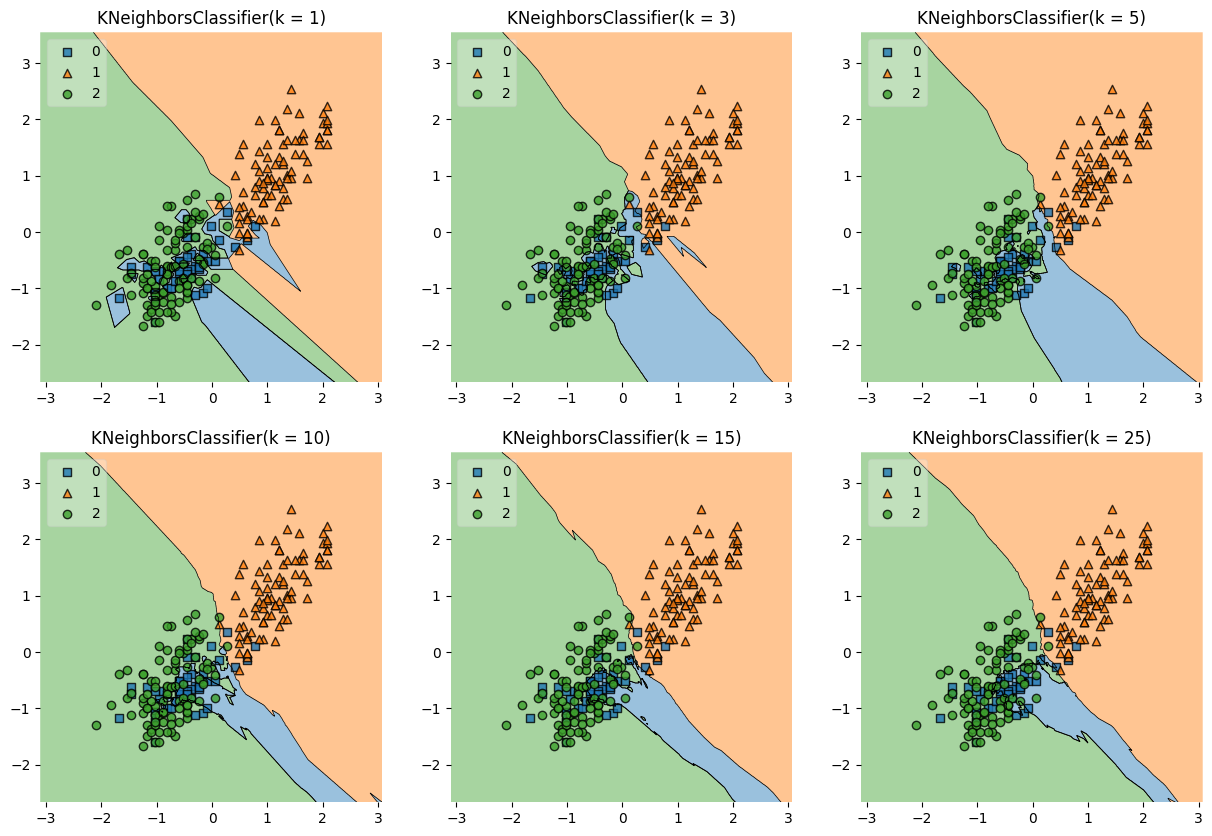

In [ ]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools
gs = gridspec.GridSpec(2, 3)
fig = plt.figure(figsize = (15, 10))

labels = ['KNeighborsClassifier(k = 1)', 'KNeighborsClassifier(k = 3)', 'KNeighborsClassifier(k = 5)', 'KNeighborsClassifier(k = 10)',
          'KNeighborsClassifier(k = 15)', 'KNeighborsClassifier(k = 25)']
for clf, lab, grd in zip([clf1, clf2, clf3, clf4, clf5, clf6], labels, itertools.product([0, 1], [0, 1, 2])):
  clf.fit(x_train, y_train)
  ax = plt.subplot(gs[grd[0], grd[1]])
  fig = plot_decision_regions(X = x_train, y = y_train.values.astype(np.int_), clf = clf, legend = 2)
  plt.title(lab)

plt.show()

**Задача 1.6 (0.5 балла)** Прокомментируйте результаты, полученные в задачах 1.3 и 1.5. Какое число соседей оптимально использовать для обучения классификатора? Поясните ваш выбор при помощи описания геометрии данных и получаемой решающей поверхности. Какие из результатов явно говорят о переобучении модели? Почему?

In [159]:
# Наилучший результат на обучающей и тестовой выборке показывает алгоритм с k = 10,
# так как он одинаково хорошо работает, как на новых данных, так и на тех, на которых обучался.
# При этом, на алгоритме с k = 1 наблюдается переобучение модели, так как она выдает хорошую точность
# на данных обучения, при этом имеет плохой результат на новых данных. Кроме того, это видно на графике,
# так как границы областей в данном случае довольно-таки гладкие и хорошо следуют класстерной структуре
# k = 25 также показывает хорошийрезультат на новых данных,
# однако это отчасти связано с тем, что экземпляров 0го класса в выборке
# гораздо меньше, чем остальных, а большое число ближайших соседей захватывает значительную часть выборки,
# поэтому высокая точность может быть обусловлена этим фактом.
# Также переобучение заметно на графике,ведь можно видеть голубую зону,
# которая появляется вокруг голубой точки, даже если она находится в скоплении
# зеленых точек. Это свидетельствует о том, что модель переобучена

### Задание 2. KNN своими руками. 2,5 балла

**Задача 2.1 (2 балла)** В данном задании мы попробуем реализовать алгоритм KNN своими руками, делать мы будем KNN именно для классификации.

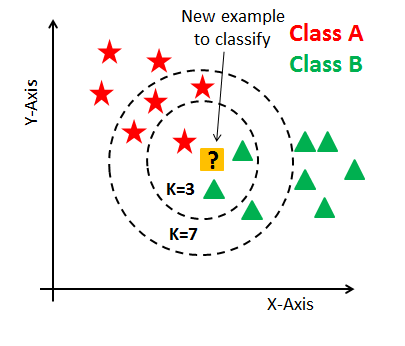

Рекомендации по реализации:
- Используйте `numpy` для представления данных в виде массивов, чтобы минимизировать преобразования.
- Избегайте циклов по всем объектам, по возможности используйте векторизированные операции.
- Обратите внимание на методы [np.linalg.norm()](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html) и [np.argsort()](https://numpy.org/doc/stable/reference/generated/numpy.argsort.html), а также на класс `collections.Counter`.
- Особый плюс, если учтёте обработку возможных ошибок.

In [160]:
import numpy as np
from collections import Counter

class KNN:
    def __init__(self, k:int):
      if k <= 0 or not isinstance(k, int):
        raise ValueError("k должно быть натуральным числом")
      self.k = k

    def fit(self, X, y):
      if not isinstance(X, np.ndarray) or not isinstance(y, np.ndarray):
        raise ValueError("Передан аргумент неверного типа. Должен быть np.ndarray")
      if len(X) != len(y) or len(X) == 0:
        raise ValueError("Неподходящая размерность переданных аргументов")
      self.X_train = X
      self.y_train = y

    def predict(self, X):
      if self.X_train is None:
        raise ValueError("Модель еще не обучена")
      if not isinstance(X, np.ndarray):
        raise ValueError("Передан аргумент неверного типа. Должен быть np.ndarray")
      #здесь мы будем хранить наши предсказанные значения для тестовой выборки
      predictions = np.empty(X.shape[0])
      for i, sample in enumerate(X):
          #находим расстояние до каждого объекта
          distances = np.array([self.count_distance(sample, train_sample)
                               for train_sample in self.X_train])
          nearest_indices = np.argsort(distances)
          nearest_labels = self.y_train[nearest_indices]
          #находим самый часто встречающееся значение среди соседей
          most_common = Counter(nearest_labels[:self.k]).most_common(1)
          predictions[i] = most_common[0][0]
      return predictions

    def count_distance(self, x, y):
      #считаем евклидову норму между векторами
      return np.linalg.norm(x - y)

In [161]:
# Не меняйте файл!
def test_knn(KNN):
  knn = KNN(k=1)
  X_train =  np.array([[1, 1], [2, 2]])
  y_train =  np.array([0, 1])
  X_test =  np.array([[1.5, 1.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [0]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[9.5, 9.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5.5, 5.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[15, 15]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5, 5], [2, 2]])
  knn.fit(X_train, y_train)
  assert all(knn.predict(X_test) == [1, 0])

In [162]:
# Если тесты эти пройдены, то все верно!
test_knn(KNN)

**Задача 2.2 (0.5 балла)** Протестируйте ваш алгоритм на данных о пингвинах. Выведите лучший получившийся результат на тестовой выборке.

In [163]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, stratify = y, random_state=42)
#отнормируем данные, используя StandartScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train[['Flipper Length (mm)', 'Body Mass (g)']])
x_test = scaler.fit_transform(x_test[['Flipper Length (mm)', 'Body Mass (g)']])
best_res = 0
best_k = 0
#проверим значения для различных k
for i in range(1, 100):
  knn = KNN(k = i)
  knn.fit(x_train, y_train.values)
  x = accuracy_score(y_test, knn.predict(x_test))
  if x > best_res:
    best_res = x
    best_k = i
print(f'лучшая точность при k = {best_k}. Она составляет {best_res}')

лучшая точность при k = 25. Она составляет 0.8673469387755102


### Задание 3: Линейная регрессия.

В этом задании мы рассмотрим различные аспекты построения линейной модели. Мы будем работать с одним из классических наборов данных в статистике, содержащим информацию о бриллиантах. Описание можно посмотреть [здесь](https://www.kaggle.com/shivam2503/diamonds).

In [164]:
data = pd.read_csv('diamonds.csv')
data.head(5)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Мы будем решать задачу предсказания цены бриллианта `price` в зависимости от его характеристик.

**Задача 3.1 (0.2 балла)** Есть ли в наборе данных пропущенные значения? Если да, удалите их.
Есть ли в наборе данных бессмысленные столбцы (признаки, не несущие дополнительной информации)? Если да, то удалите их.

In [165]:
#в данных пропущенных значений нет
print(data.isna().sum())
#в наборе есть бесмысленный столбец Unnamed: 0, который не отвечает ни за какой параметр бриллианта
data = data.drop('Unnamed: 0', axis = 1)

Unnamed: 0    0
carat         0
cut           0
color         0
clarity       0
depth         0
table         0
price         0
x             0
y             0
z             0
dtype: int64


**Задача 3.2 (0.2 балла)** Линейная регрессия основана на предположении о линейной связи между признаками и целевой переменной, а потому перед выбором переменных для включения в модель имеет смысл проверить, насколько эта связь выполняется. Для следующих пунктов нам также потребуются выборочные корреляции между признаками. Постройте матрицу корреляций между всеми вещественными признаками и целевой переменной (то есть в этой матрице будет $k+1$ строка, где $k$ – количество вещественных признаков).

Какие вещественные признаки имеют наибольшую корреляцию с целевой переменной?

Text(0.5, 1.0, 'Correlation heatmap')

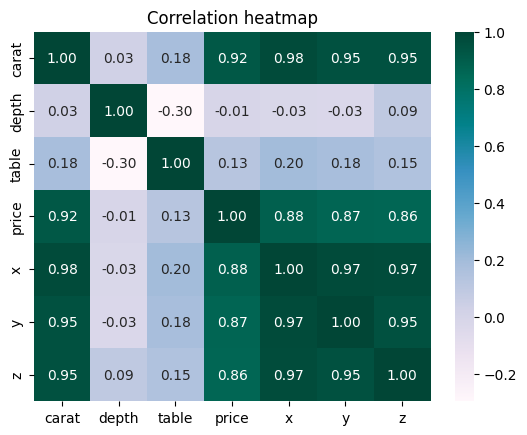

In [166]:
import seaborn as sns
ax = sns.heatmap(data.corr(numeric_only=True),cmap="PuBuGn", annot=True, fmt="0.2f")
ax.set_title("Correlation heatmap")
#видим, что наибольшую корреляцию с ценой имеет размер бриллианта, а также количество карат.
#Все остальные вещественные признаки мало влияют на цену

**Задача 3.3 (0.2 балла)** Так как линейная модель складывает значения признаков с некоторыми весами, нам нужно аккуратно обработать категориальные признаки. Закодируйте категориальные признаки методом OneHot-кодирования (`pd.get_dummies()` или `OneHotEncoder` из `sklearn`).

In [167]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse_output=False)
data_encoded = ohe.fit_transform(data[['cut', 'color', 'clarity']])
data_encoded = pd.DataFrame(data_encoded, columns = ohe.get_feature_names_out(['cut', 'color', 'clarity']), index = data.index)
data = pd.concat([data, data_encoded], axis = 1)
data.drop(['cut', 'color', 'clarity'], axis = 1)

,carat,depth,table,price,x,y,z,cut_Fair,cut_Good,cut_Ideal,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.21,59.8,61.0,326,3.89,3.84,2.31,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.23,56.9,65.0,327,4.05,4.07,2.31,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.29,62.4,58.0,334,4.20,4.23,2.63,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.31,63.3,58.0,335,4.34,4.35,2.75,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53935,0.72,60.8,57.0,2757,5.75,5.76,3.50,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
53936,0.72,63.1,55.0,2757,5.69,5.75,3.61,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
53937,0.70,62.8,60.0,2757,5.66,5.68,3.56,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
53938,0.86,61.0,58.0,2757,6.15,6.12,3.74,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


**Задача 3.4 (0.2 балла)** Разделите выборку на тренировочную и тестовую. Долю тестовой выборки укажите равной 0.3. Не забудьте про параметр `stratify`.

In [168]:
y = data['price']
x = data.drop('price', axis = 1)
stratify = x['cut'].astype(str) + x['color'].astype(str)
#разделим выборку на тестовую и обучающую
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, stratify = stratify, random_state=42)
#удалим столбцы с категориальными признаками, чтобы они не мешали нам при обучении регрессии
x_train = x_train.drop(['cut', 'color', 'clarity'], axis = 1)
x_test = x_test.drop(['cut', 'color', 'clarity'], axis = 1)

**Задача 3.5 (0.3 балла)** Зачастую при использовании линейных моделей вещественные признаки масштабируются. При этом оценки коэффициентов теряют прямую статистическую интерпретацию ("при увеличении $X_1$ на 1, $y$ увеличивается на $w_1$"), но приобретают свойства, полезные в задачах машинного обучения. В этой задаче стандартизируйте вещественные признаки в тренировочной и тестовой выборках с помощью `StandardScaler`.

In [169]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train[['carat', 'depth', 'table', 'x', 'y', 'z']] = scaler.fit_transform(x_train[['carat', 'depth', 'table', 'x', 'y', 'z']])
x_test[['carat', 'depth', 'table', 'x', 'y', 'z']] = scaler.fit_transform(x_test[['carat', 'depth', 'table', 'x', 'y', 'z']])

Объясните, как это повлияет на интерпретацию коэффициентов линейной регрессии.

In [170]:
#теперь мы можем отследить значимость признака по модулю коэффициента в модели около него
# до этого мы так делать не могли, так как наши данные не были отмасштабированными
# к примеру среднее значение в столбце x было 6, а в столбце table 60. Тогда модель вероятнее
# всего подобрала бы для столбца x более большой коэффициент, но это не значило бы, что
# параметр x важнее параметра table. Просто наши данные не были отмасштабированными.

**Задача 3.6 (0.2 балла)** Оцените линейную регрессию на тренировочной выборке. Выведите среднеквадратичную ошибку на тренировочной и тестовой выборках.

In [171]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
lr = LinearRegression().fit(x_train, y_train)
print(f'MSE train {mean_squared_error(y_train, lr.predict(x_train))}')
print(f'MSE test {mean_squared_error(y_test, lr.predict(x_test))}')

MSE train 1279117.2504342753
MSE test 1278427.2186921518


**Задача 3.7 (0.3 балла)** Изучите [документацию](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) модуля `LinearRegression` и выведите полученные оценки коэффициентов. Назовите вещественные переменные, оценки коэффициентов которых по модулю на порядок превышают оценки прочих вещественных переменных.

In [172]:
for feature, coeff in zip(x_train.columns, lr.coef_):
  print(f'{feature}  {coeff}')

#видим, что наибольшее влияние на цену бриллианта оказывает carat, так как у этого признака наибольший коэффициент,
# также стоимость камня сильно увеличивается, если он имеет clarity WS1, WS2 или IF. При этом, если clarity равен I1,
# то это очень сильно снижает цену. Кроме того, цена сильно снижается, если у бриллианта большой параметр x
# (видимо более длинные бриллианты ценятся меньше)

carat  5303.740797519871
depth  -86.76991111501752
table  -60.5914101225075
x  -1093.6342061759617
y  54.37574851342511
z  -106.28486874768194
cut_Fair  -570.9733006428554
cut_Good  7.137277055527923
cut_Ideal  247.29854811937986
cut_Premium  178.48099595263437
cut_Very Good  138.05647951531296
color_D  817.1997559543912
color_E  613.6780757242076
color_F  550.307435010102
color_G  347.66061137775455
color_H  -150.48101044794925
color_I  -646.0436240113746
color_J  -1532.3212436071358
clarity_I1  -3758.6007336703233
clarity_IF  1517.2575484454471
clarity_SI1  -145.7106384744734
clarity_SI2  -1116.8180457273306
clarity_VS1  755.3966873784063
clarity_VS2  444.35408161186405
clarity_VVS1  1168.712568888175
clarity_VVS2  1135.4085315482312


**Задача 3.8 (0.5 балла)** Как можно заметить из анализа корреляционной матрицы в задаче 3.3, между некоторыми признаками имеется сильная корреляция, что может быть индикатором проблемы *мультиколлинеарности*. Различия в порядке коэффициентов, выявленные в предыдущей задаче также намекают на её присутствие. Как известно, для решения этой проблемы можно либо исключить некоторые признаки из модели, либо использовать регуляризацию. Мы воспользуемся вторым вариантом.

Вспомним, что смысл регуляризации заключается в том, чтобы изменить функцию потерь так, чтобы устранить проблемы, появляющиеся из-за мультиколлинеарности. При L1-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \alpha\sum_{i=1}^k|w_i|
$$

Такая модель называется Lasso-регрессией.

При L2-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \alpha\|w\|^2
$$

Такая модель называется Ridge-регрессией.

Обучите Lasso-регрессию и Ridge-регрессию, установив гиперпараметр регуляризации равным 10. Для этого используйте модули `Lasso` и `Ridge` из `sklearn`. Сильно ли уменьшились веса? Сделайте вывод о том, насколько сильно проблема мультиколлинеарности проявлялась в изначальной регрессии.

In [173]:
from sklearn.linear_model import Lasso, Ridge
lasso = Lasso(10).fit(x_train, y_train)
for feature, coeff1, coeff2 in zip(x_train.columns, lasso.coef_, lr.coef_):
  #выведем на какую долю от изначального значения изменились коэффициенты
  print(f'{feature}  {(coeff1 - coeff2) / coeff2}')
#видим, что коэффициенты для некоторых признаков изменились значительно
#несколько признаков для модели оказались не важны, а коэффициенты у некоторых изменились более, чем на 40 процентов
#это свидетельствует о сильной проблеме мультиколлинеарности в изначальной регрессии

carat  -0.09092632762651877
depth  0.15089093994841224
table  0.31998416351146386
x  -0.407352564418904
y  -1.0
z  -0.16484878170381767
cut_Fair  -0.269144445993482
cut_Good  -3.741270714688756
cut_Ideal  -0.6520154757272546
cut_Premium  -1.0
cut_Very Good  -1.0
color_D  -0.6048509306905852
color_E  -0.7423441833655615
color_F  -0.8062364836192935
color_G  -1.0
color_H  1.910402423502697
color_I  0.34056682298779895
color_J  0.0756577044940012
clarity_I1  -0.06172036031061415
clarity_IF  -0.5571753645110412
clarity_SI1  3.251597162867093
clarity_SI2  0.36908805497828406
clarity_VS1  -0.7944040890143119
clarity_VS2  -1.044704430275577
clarity_VVS1  -0.5721159359938013
clarity_VVS2  -0.5442570184498255


In [174]:
ridge = Ridge(10).fit(x_train, y_train)
for feature, coeff1, coeff2 in zip(x_train.columns, ridge.coef_, lr.coef_):
  print(f'{feature}  {(coeff1 - coeff2) / coeff2}')
#видим, что при применении Ridge-регрессии коэффициенты модели практически не поменялись

carat  -0.0075381753378307515
depth  -0.029939276556011925
table  0.00562564836454851
x  -0.05259925010428415
y  -0.16287409914947062
z  0.11591981464318596
cut_Fair  0.004890593601235111
cut_Good  0.008982892348256657
cut_Ideal  0.004417657038495849
cut_Premium  -0.0008335475460407057
cut_Very Good  0.01292642843501686
color_D  -0.005731216054641437
color_E  -0.005971361648239288
color_F  -0.00628957831962616
color_G  -0.00470450244080038
color_H  0.003086818838855491
color_I  -0.004976434677746177
color_J  -0.0069791682154020825
clarity_I1  -0.01843699085145473
clarity_IF  -0.012648879414550972
clarity_SI1  0.05293093272127793
clarity_SI2  0.0030198358958962103
clarity_VS1  -0.012612386164734382
clarity_VS2  -0.018089985873262403
clarity_VVS1  -0.009601305487258942
clarity_VVS2  -0.00901313656718031


**Задача 3.9 (0.5 балла)** Как обсуждалось на семинарах, Lasso-регрессию можно использовать для отбора наиболее информативных признаков. Для следующих значений параметра регуляриазции $\alpha$: 0.1, 1, 10, 100, 200 –  обучите Lasso- и Ridge-регрессии и постройте график измненения евклидовой нормы весов (`np.linalg.norm()` от вектора оценок коэффициентов) в зависимости от параметра $\alpha$. Как известно, норма является численной характеристикой величины вектора, а потому по норме можно судить о том, насколько большие элементы содержит вектор оценок коэффициентов.

Какой метод сильнее снижает норму коэффициентов? Поясните, почему Lasso-регрессию часто используют для отбора признаков.

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.376e+07, tolerance: 5.948e+07
  model = cd_fast.enet_coordinate_descent(


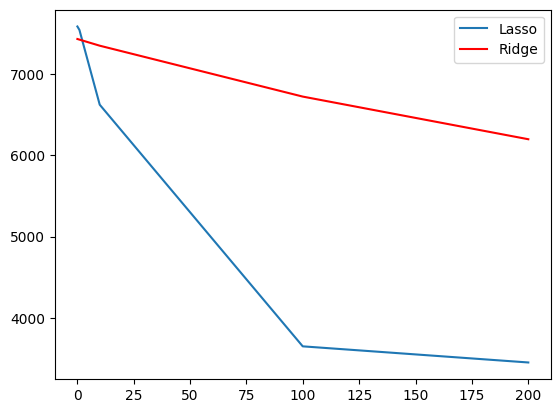

In [175]:
las1 = Lasso(0.1).fit(x_train, y_train)
las2 = Lasso(1).fit(x_train, y_train)
las3 = Lasso(10).fit(x_train, y_train)
las4 = Lasso(100).fit(x_train, y_train)
las5 = Lasso(200).fit(x_train, y_train)
rid1 = Ridge(0.1).fit(x_train, y_train)
rid2 = Ridge(1).fit(x_train, y_train)
rid3 = Ridge(10).fit(x_train, y_train)
rid4 = Ridge(100).fit(x_train, y_train)
rid5 = Ridge(200).fit(x_train, y_train)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
x = [0.1, 1, 10, 100, 200]
y = [np.linalg.norm(las1.coef_), np.linalg.norm(las2.coef_),np.linalg.norm(las3.coef_),np.linalg.norm(las4.coef_),np.linalg.norm(las5.coef_)]
ax.plot(x, y)
y = [np.linalg.norm(rid1.coef_), np.linalg.norm(rid2.coef_),np.linalg.norm(rid3.coef_),np.linalg.norm(rid4.coef_),np.linalg.norm(rid5.coef_)]
ax.plot(x, y, color = 'r')
plt.legend(['Lasso', 'Ridge'])

#Как видно по графику, метод лассо сильнее снижает норму коэффициентов, чем метод Ridge.
# Метод Lasso часто используют для отбора признаков, потому что он построен так, что наименнее важные признаки приравниваются к 0
# Это происходит потому, что "квадратичный штраф" за признаки сильно увеличивает ошибку модели. Поэтому модель зануляет
# наименее важные признаки, либо сильно уменьшает их коэффициент

**Задача 3.10 (0.5 балла)**
В зависимости от значения параметра $\alpha$ в Lasso-регрессии зануляются разные оценки коэффициентов. Оптимальное значение $\alpha$ можно подобрать, например, при помощи кросс-валидации по тренировочной выборке.

Для проведения кросс-валидации можно использовать модуль `LassoCV`. Этот модуль принимает список значений $\alpha$ (параметр `alphas`) и при обучении проводит кросс-валидацию для каждого значения из этого списка, сохраняя MSE на каждом участке кросс-валидации (количество участков – параметр `cv`) в матрицу ошибок (то есть итоговая матрица будет иметь размер `len(alphas)` $\times$ `cv`). После обучения модели матрицу ошибок можно получить, обратившись к атрибуту `.mse_path_`.

Заметим, что модель может использовать $\alpha$ не в том порядке, в котором вы подаёте их в функцию: для определения порядка используйте атрибут `.alphas_` Установите количество участков для кросс-валидации (параметр `cv`) равным 5.

Усредните ошибки для каждого значения $\alpha$ (то есть по строкам матрицы ошибок) и выберите то значение, которое даёт наибольшее качество.

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1596570574.8162842, tolerance: 47752671.314922
  model = cd_fast.enet_coordinate_descent_gram(


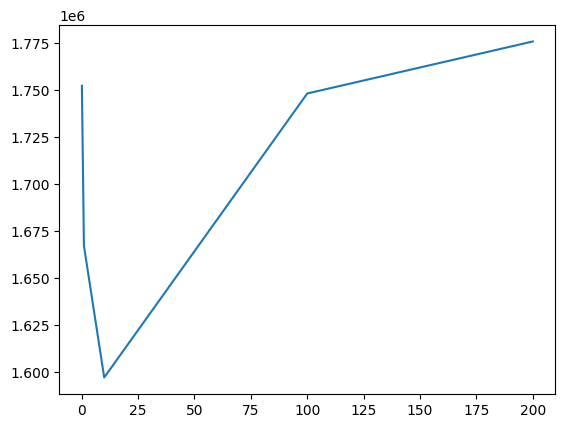

In [176]:
from sklearn.linear_model import LassoCV
lcv = LassoCV(alphas = [0.1, 1, 10, 100, 200], cv = 5, random_state = 42).fit(x_train, y_train)
d = lcv.mse_path_.mean(axis = 0)
fig = plt.figure()
ax = fig.add_subplot()
#порядок, в котором использовалась альфа посмотрел, через lcv.alphas_
ax.plot([200, 100, 10, 1, 0.1], d)
#как видно по графику наибольшее значение дает альфа равное 200, при этом наименьшая средняя ошибка наблюдается при альфа равной 10

**Задача 3.11 (0.5 балла)** Обучите итоговую Lasso-регрессию с выбранным параметром $\alpha$ на тренировочной выборке. Выведите полученные коэффициенты и прокомментируйте, какие признаки оказались неинформативными, а какие – наиболее информативными. Приведите возможное смысловое объяснение этого результата.

In [177]:
lcv = LassoCV(alphas = [10], cv = 5, random_state=42).fit(x_train, y_train)
for feature, coeff in zip(x_train.columns, lcv.coef_):
  print(f'{feature}  {coeff}')
#видим, что неинформативными признаками оказались y, cut_Premium, cut_Very Good и colorG
# при этом наиболее информативным признаком является carat. Подобный результат может быть вызван тем, что
# наибольшее влияние на цену камня оказывает его размер (carat), при этом форма бриллианта не
# так существенна, поэтому модель исключила из рассмотрения признак y. При этом модель также выбросила из рассмотрения
# признаки указывающие на обработку и один из цветов камня. Это может быть связано с тем, что подобные камни очень редки,
# а значит наличие данных признаков-свидетельство о выбросе из большинства данных, поэтому модель исключила их из рассмотрения
# для увеличения точности на большинстве камней

carat  4821.491124118445
depth  -99.8627045624027
table  -79.9797018065381
x  -648.1395077539513
y  -0.0
z  -88.76393762107641
cut_Fair  -417.29900796426426
cut_Good  -19.565208574938687
cut_Ideal  86.05606762066303
cut_Premium  0.0
cut_Very Good  0.0
color_D  322.91572300525866
color_E  158.11772575137147
color_F  106.62950369800448
color_G  0.0
color_H  -437.96029749884616
color_I  -866.0646485524526
color_J  -1648.2531514458449
clarity_I1  -3526.6185421244522
clarity_IF  671.8790208332264
clarity_SI1  -619.5029371376238
clarity_SI2  -1529.0222459894794
clarity_VS1  155.30647009713445
clarity_VS2  -19.86459605908569
clarity_VVS1  500.07348363099675
clarity_VVS2  517.4544694452961


**Задача 3.12 (0.4 балла)** Сделайте предсказания обученной Lasso-регрессии на тестовой выборке и сравните среднеквадратичную ошибку с ошибкой обычной линейной регрессии из задачи 3.7. Какую модель лучше использовать для предсказаний? Приведите возможное объяснение, почему одна модель оказалась лучше другой.

In [178]:
mean_squared_error(y_test, lcv.predict(x_test))

# Как видно среднеквадратичная ошибка у модели, обученной при помощи лассо больше, чем у обычной
# это может свидетельствовать о том, что в данных мало "шума", или о том, что регуляризация при помощи Лассо излишняя,
# так как были убраны важные признаки. В таком случае лучше использовать обычную линейную регрессию

1327430.0511718392